In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import re
import pysam
from Bio.Seq import Seq
import pyranges as pr
from rapidfuzz import fuzz
import mappy as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nbp = 16
n_mismatch = 10
ref_barcode = 'A' * nbp
test_barcode = 'A' * nbp

for i in range(n_mismatch):
    test_barcode = test_barcode[:i] + 'T' + test_barcode[i+1:]
    result = fuzz.partial_ratio_alignment(test_barcode, ref_barcode)
    print(f"BP MISMATCHES: {i+1} SCORE: {result.score:.1f}")

BP MISMATCHES: 1 SCORE: 96.8
BP MISMATCHES: 2 SCORE: 93.3
BP MISMATCHES: 3 SCORE: 89.7
BP MISMATCHES: 4 SCORE: 85.7
BP MISMATCHES: 5 SCORE: 81.5
BP MISMATCHES: 6 SCORE: 76.9
BP MISMATCHES: 7 SCORE: 72.0
BP MISMATCHES: 8 SCORE: 66.7
BP MISMATCHES: 9 SCORE: 60.9
BP MISMATCHES: 10 SCORE: 54.5


# Check some sequences

In [3]:
fpath = "sample.fastq.gz"
fastq_file = pysam.FastqFile(fpath)

count = -1
stop = 5
for read in fastq_file:
    count += 1
    if count == stop:
        break

    read_name = read.name
    print("\n=====================")
    print(f"{read_name=}") 
    print(read.sequence)


read_name='7ca01f6b-1455-4f05-ba7a-4b983ad8f534'
TTAACTGATTTCAATGGAGTGGGTGTTTTATGCAGTTCCATCATCTACCGTGACAAGAAAGTTGTCAGTGTCTTTGTGTTTCTGTTGGTGCTGATATTGCAAGCAGTGGTATCAACGCAGAGACATGGGGAAAATTTCATTTCAAATGCCAAAACCATCCTATAAAGAAAAACTTACCTTCTTAGGTCAAATCTCTAATATTTGACTAGATTCAAAAAGTTTATTTCTGGCCAGGCACAGTAGCTTACTCCTGAAATCCCAGCACTTTGGGAGACCAAGGTGGGAGGATCACTTGAGGCCAGGAATTCAAGACCAGCTTGAGCGACATAGCAAGACCCCATTTCTACAAAAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCTGGGGAGCTGCTCTCATCACAAGATCGGAAGAGCGTCGTGTAGGAAAGATAGAGCGACAGACGGAGTCTAAAGACACCGACAACTTTCTTGTCAT

read_name='ffa5cb0c-acb8-49b3-b0cb-9c757ec92615'
AACATTGCTTCGTTCCGGTGCACTATGGTGATGGGTGTTTATGGATATCCTTCTGTGACAAGAAAGTTGTCGGTGTCTTTGTGTTTCTGTTGGTGCTGTCATTGCAAGCAGTGGTATCAACGCAGAGTACATGGGTAAATGAAAGATACAGCCAGGCGCTGGGCTCATGCTTGTAATCCCAGCACTTTGCGGGGCCAAGGCGGGCGGATCACGAGGTCAGGAGTTCAAGACCAGCCTGGCCAACATGGTGAAACCCCGTCTCTACTAAAAATACAAAAGTTAGCTGGGTGTGGTGATGGGCACCAGCTACTCAGGAGGCTGAGGCAGGAGAATTGTTTGAACCCGGGAAGCGGAGGTTGCAGTGAGCCGAGATTACACCATTGCACTCCAGCCTGGGCGACAGAGCAAGACTTACTTAAAGTA

# build the barcode dictionary

In [4]:
# load the demultiplexed barcodes
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/demultiplex/Gridr1.putative_bc.csv"
df = pd.read_csv(fpath)
df = df[df['putative_bc'].notna()] # drop unidentifiable reads
print(df.dtypes)
df = df.set_index('read_id')
df.columns = ['barcode', 'bc_min_q', 'umi', 'umi_end', 'pre_barcode', 'post_umi']
df['strand'] = np.where(df['umi_end'] < 0, 'reverse', 'forward')
df['polyTail'] = np.where(df['umi_end'] < 0, 'A', 'T')
read_lookup = df.to_dict(orient='index')
print(f"{df.shape=}")
df.head()

read_id               object
putative_bc           object
putative_bc_min_q    float64
putative_umi          object
umi_end              float64
pre_bc_flanking       object
post_umi_flanking     object
dtype: object
df.shape=(12959895, 8)


,barcode,bc_min_q,umi,umi_end,pre_barcode,post_umi,strand,polyTail
read_id,,,,,,,,
ffa5cb0c-acb8-49b3-b0cb-9c757ec92615,GATAGAAGTACCAGAG,4.0,GCTAATGAGTAG,-104.0,GATCT,TTTTT,reverse,A
0f84e905-dfbf-4343-ac98-5a9a4d1c22ea,CCGCGAGTCATGAGTC,6.0,GGGACAGGTTAA,150.0,GATCT,TTTTT,forward,T
13d4e220-ff2c-4c0e-aa40-afb93c5fa937,CGATGCGTCATGAGTC,17.0,CATGCTATGCGT,-98.0,GATCT,TTTTT,reverse,A
d15f9cc4-6df7-4f79-a749-341256f06bac,ACCCTCACAACAGATA,19.0,ACGAGGATGTAT,-64.0,GATCT,TTTTT,reverse,A
a96ffa76-ee03-47d0-a17f-87bba378e16c,AGCGCCACAGCACACC,9.0,GGCTTGGTCATT,-101.0,GATCT,TTTTT,reverse,A


In [5]:
read_lookup['ffa5cb0c-acb8-49b3-b0cb-9c757ec92615']

{'barcode': 'GATAGAAGTACCAGAG',
 'bc_min_q': 4.0,
 'umi': 'GCTAATGAGTAG',
 'umi_end': -104.0,
 'pre_barcode': 'GATCT',
 'post_umi': 'TTTTT',
 'strand': 'reverse',
 'polyTail': 'A'}

In [6]:
def find_fuzzy(seq, tgt, min_sim):
  """
  Finds all fuzzy matches of the target sequence within the main sequence recursively.

  Args:
      seq: The main sequence to search.
      tgt: The target sequence to find fuzzy matches for.
      min_sim: Minimum similarity threshold (0-100).

  Returns:
      A list of tuples containing the matching character, matched substring, start and end positions, and similarity score.
  """
  matches = []
  best_match = None

  # Find the best alignment using a sliding window and update best_match
  for i in range(len(seq) - len(tgt) + 1):
    sub = seq[i:i + len(tgt)]
    score = fuzz.partial_ratio(tgt, sub)
    if score >= min_sim and (not best_match or score > best_match[4]):
      best_match = (seq[i], sub, i, i + len(tgt) - 1, score)

  # If a match is found, record it and continue recursively
  if best_match:
    matches.append(best_match)
    rem_seq = seq[:best_match[2]] + seq[best_match[3] + 1:]
    matches.extend(find_fuzzy(rem_seq, tgt, min_sim))

  return matches

In [7]:
fpath = "sample.fastq.gz"
fastq_file = pysam.FastqFile(fpath)

truseq = "ACACTCTTTCCCTACACGACGCTCTTCCGATCT"

count = -1
stop = 10
for read in fastq_file:
    count += 1
    if count == stop:
        break

    read_name = read.name
    print("\n=====================")
    print(f"{read_name=}") 
    
    if not read_name in read_lookup:
        print('NO BARCODE!')
        continue

    d = read_lookup[read_name]
    print(f"UMI flanking seq: {d['post_umi']}")

    barcode = d['barcode']
    umi = d['umi']

    # if found on reverse
    seq = read.sequence
    raw_seq = read.sequence
    if d['strand'] == 'reverse':
        print("FOUND ON REVERSE STRAND")
        seq = str(Seq(seq).reverse_complement())
        
    color_bc = f"\033[92m{barcode}\033[0m"
    color_umi = f"\033[93m{umi}\033[0m"
    
    print(f"barcode + umi: {color_bc}{color_umi}")

    c = [92, 93, 94]

    for i, search in enumerate([barcode, umi, truseq]):
        
        matches = find_fuzzy(seq, search, min_sim=88)
        for match in matches:
            print(f"match score: {match[4]}")
            match_red = f"\033[{c[i]}m{match[1]}\033[0m"
            seq = re.sub(match[1], match_red, seq)
    print()
    print("Processed read:")    
    print(seq)
    print()
    print("Raw read:")    
    print(raw_seq)


read_name='7ca01f6b-1455-4f05-ba7a-4b983ad8f534'
NO BARCODE!

read_name='ffa5cb0c-acb8-49b3-b0cb-9c757ec92615'
UMI flanking seq: TTTTT
FOUND ON REVERSE STRAND
barcode + umi: GATAGAAGTACCAGAGGCTAATGAGTAG
match score: 100.0
match score: 100.0
match score: 92.06349206349206

Processed read:
TGTGACAAGAAAGTTGTCGGTGTCTTTGTGACTTGCCTGTCGCTCCCTATCTTCCTACACGACGCTCTTCCGATCTGATAGAAGTACCAGAGGCTAATGAGTAGTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACTGACTTACTTACTTACTTTAAGTAAGTCTTGCTCTGTCGCCCAGGCTGGAGTGCAATGGTGTAATCTCGGCTCACTGCAACCTCCGCTTCCCGGGTTCAAACAATTCTCCTGCCTCAGCCTCCTGAGTAGCTGGTGCCCATCACCACACCCAGCTAACTTTTGTATTTTTAGTAGAGACGGGGTTTCACCATGTTGGCCAGGCTGGTCTTGAACTCCTGACCTCGTGATCCGCCCGCCTTGGCCCCGCAAAGTGCTGGGATTACAAGCATGAGCCCAGCGCCTGGCTGTATCTTTCATTTACCCATGTACTCTGCGTTGATACCACTGCTTGCAATGACAGCACCAACAGAAACACAAAGACACCGACAACTTTCTTGTCACAGAAGGATATCCATAAACACCCATCACCATAGTGCACCGGAACGAAGCAATGTT

Raw read:
AACATTGCTTCGTTCCGGTGCACTATGGTGATGGGTGTTTATGGATATCCTTCTGTGACAAGAAAGTTGTCGGTGTCTTTGTGTTTCTGTTGGTGCTGTCATTGCAAGCAGTGGTATCAACGCAGAG

# Quantify the number of bases required to reach

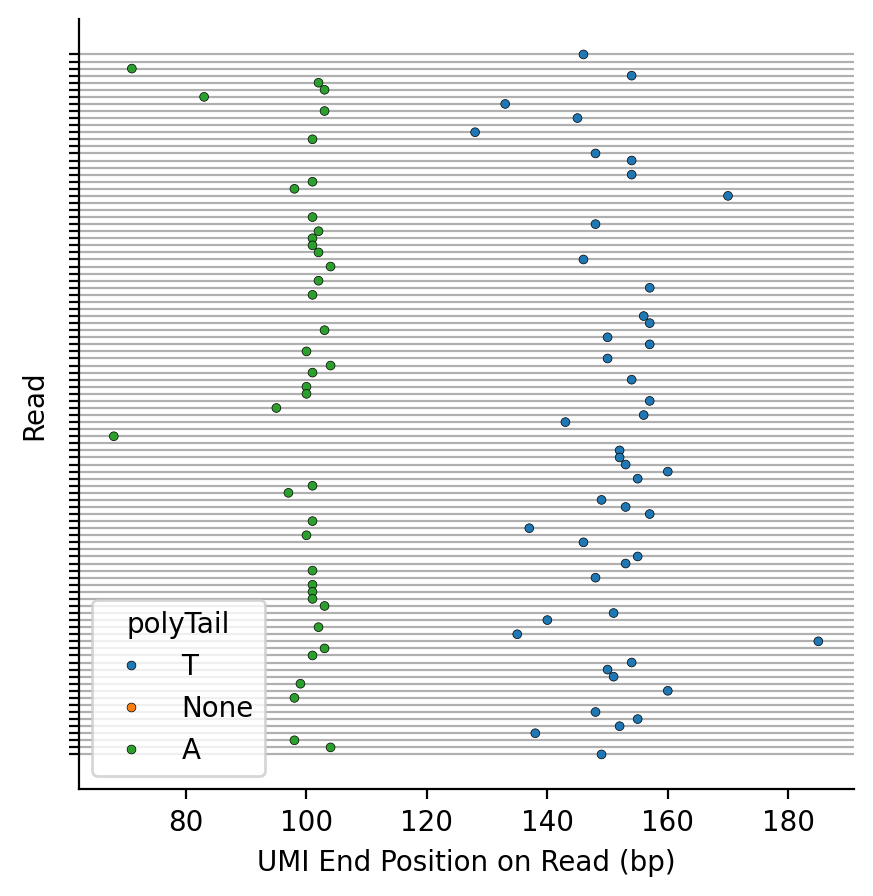

In [24]:
fpath = "sample.fastq.gz"
fastq_file = pysam.FastqFile(fpath)

res = []
for read in fastq_file:
    read_name = read.name
    
    if not read_name in read_lookup:
        d = {
            'read_name' : read_name,
            'polyTail' : 'None',
        }
    else:
        d = read_lookup[read_name]
        d['read_name'] = read_name
        
    res.append(d)

res = pd.DataFrame(res)
res['umi_end'] = res['umi_end'].abs()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5
sns.scatterplot(data=res.sample(100), 
                x='umi_end',
                y='read_name',
                hue='polyTail',
                ec='k',
                zorder=10,
                s=10,
                )

plt.grid(axis='y', zorder=0)
plt.gca().set_yticklabels([])
plt.ylabel('Read')
plt.xlabel('UMI End Position on Read (bp)')
sns.despine()

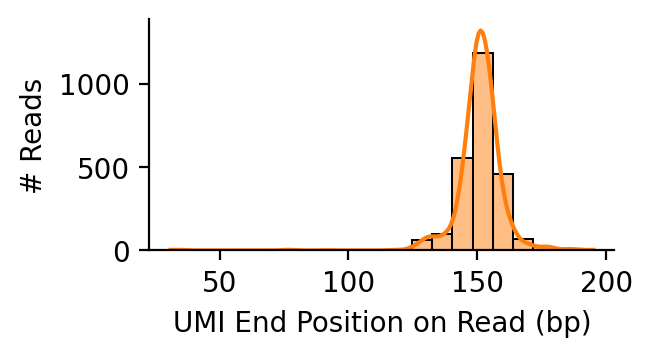

In [25]:
pdf = res.copy()
pdf = pdf[pdf['polyTail'] == 'T']

plt.rcParams['figure.figsize'] = 3, 1.5
sns.histplot(data=pdf, 
             x='umi_end',
             bins=21,
             color='C1',
             kde=True)

plt.ylabel('# Reads')
plt.xlabel('UMI End Position on Read (bp)')
sns.despine()

/tmp/ipykernel_1443245/1250900702.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=t,
/tmp/ipykernel_1443245/1250900702.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Detectable', 'Undetectable', "None"])


polyTail
T       0.4946
A       0.3714
None    0.1340
Name: proportion, dtype: float64

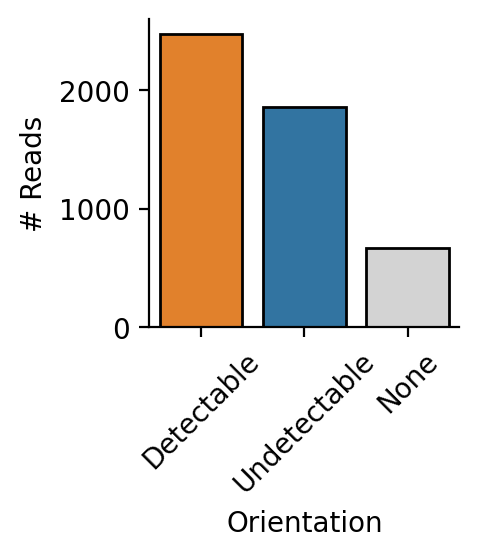

In [34]:
t = pd.DataFrame(res['polyTail'].value_counts()).reset_index(drop=False)

plt.rcParams['figure.figsize'] = 2, 2
sns.barplot(data=t,
            x='polyTail',
            y='count',
            palette=['C1', 'C0', 'lightgrey'],
            ec='k')

plt.gca().set_xticklabels(['Detectable', 'Undetectable', "None"])
plt.gca().tick_params(axis='x', rotation=45)
plt.ylabel('# Reads')
plt.xlabel('Orientation')
sns.despine()

res['polyTail'].value_counts(normalize=True)